In [5]:
import housing
%matplotlib inline

My main
Variance score: 0.70


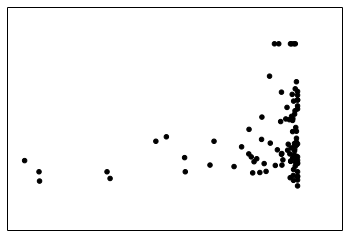

In [6]:
housing.main()